In [1]:
%pylab inline
import numpy as np



Populating the interactive namespace from numpy and matplotlib


### Ecuacion Difusion en Reactor Tubular

a. Tenemos las ecuaciones que describen el intercambio de calor entre 2 materiales en un reactor tubular, considerando despreciable el ancho del mismo, de la siguiente manera:


Dado que $\frac{dc}{dr} = 0 $ cuando r=0 tenemos que $\frac{d^2c}{dr^2}$ cuando r tiende a 0 es un límite de la forma 0/0. Así, usamos l'Hopital en  ambas ecuaciones por lo que obtenemos que $\frac{dc}{dr} * \frac{1}{r} = \frac{d^2c}{dr^2}$ para r tendiendo a 0 y con $\frac{dT}{dr}=0$ en r=0 entonces nos queda $\frac{d^2c}{dr^2} * \frac{1}{r} = * \frac{dT}{dr}$ de la forma que:


$$\frac{dc}{dt}= (−\nu\frac{dc}{dz}) + D(\frac{dc}{dz dz} + 2 \frac{dc}{dr}) − r(c,T)$$
$$\frac{dT}{dt}=−\nu\frac{dT}{dz} + \lambda\frac{1}{\rho Cp}D(\frac{dT}{dz dz} + 2\frac{dT}{dr dr}) − \Delta H\frac{1}{\rho Cp}r(c,T)$$


Usamos las constantes para cobre y glicol de propileno, del libro Folgen de "Elements of chemical reaction engenieering" 

In [2]:

#definicion de constantes, variables y pasos de cada ecuación diferencial
n_x = 10
n_t = 20
L = 30 #esos son los valores que toca ver para un caso determinado
R = 1 # radio reservorio

r = np.linspace(0.1,R,n_x)
z = np.linspace(0.1,L,n_x)

dr = r[1]-r[0]
dz = z[1]-z[0]

#trate de hacer el dt como en la wave equation pero no veo como despejarlo, entonces lo definiremos a ojo
dt = 0.00000000000001
d_H = -525676 #entalpia
C_p = 192.59 #calor especifico
rho = 1040 #densidad
T_w = 100 #temperatura del reservorio
lamda = 200
k_0 = 10
E = 10
D = 10**-9 #difusividad
h = R*3.15


In [3]:
#Funcion r, en este caso no hay cabida 
def rf(c1, T1): 
    if(c1 >= 0 and T1 >= 0):
        return k_0 + np.exp(-E/(R*T1))*(c1**2)
    else:
        return 0

#Funcion v
def v_over_vmax(r1): #funcion normalizada de la velocidad de difusion
    return (1-(r1/R)**2)

In [19]:
T_past = np.ones((n_x, n_x))
#declaramos los arreglos para T y c que guardaran todo de aca e adelante, pero necesitamos los iniciales, entonces:
c_past = np.zeros((n_x, n_x))
T_0 = 20*np.ones((n_x, n_x))#en Celsius, la temperatura inicial comienza a T ambiente
#declaramos que la concentracion empieza con inicial de 5
c_0 = 5*np.ones((n_x, n_x))

for i in range(0,n_x):
    #dependencia de r
    for j in range(0,n_x):
        #dependencia de z
        
        T_0[i,j]=100 + 0.05*i #arbitrariamente elegimos que la temperatura aumente 0.05 grados por iteracion y que no dependa de z
        c_0[i,j]=100 - 0.005*j #arbitrariamente elijo que la concentracion disminuya a medida que atravieza en z

        
#dado que necesitamos inciar el llenado de los arreglos ya con los valores iniciales, llenamos lalista asi como 
#vimos en clase
T_pres = 25*T_0.copy()
c_pres = c_0.copy()

#ahora definimos las condiciones de frontera en cada caso
                        
#f es la funcion que queremos derivar, i es r, j es z. Estas son las primeras derivadas

def derivada1_r(f,i,j):
                
    if(i==len(f)): #cuando R=r
        return (h/lamda)*(Tw - f[i][j])
    #elif(i == 0):
        #return 0
    else:
        return (f[i+1][j]-f[i-1][j])/(2*dr) 
         
    
def derivada1_z(f,i,j):
                
    if(j==len(f)):
        return 0
    #elif(j == 0):
        #return 0
    else:
        return (f[i][j]-f[i][j-1])/(2*dz) 

#f es la funcion que queremos derivar, i es r, j es z. Estas son las segundas derivadas. 
def derivada2_r(f, i, j):
    
    if(i==len(f)): 
        return (h/lamda)*(Tw - f(i,j))
    #elif(i == 0):
    else:
        return (f[i+1][j] + 2*f[i][j]-f[i-1][j])/(2*dr) 

def derivada2_z(f,i,j):
         
    #if(j == len(f)):
        #return 0
    #elif(j == 0):
        #return 0
    return (f[i][j] + 2*f[i][j-1]-f[i][j-2])/(2*dz) 

In [20]:
##Discretizacion en el timempo, bellas condiciones de frontera de Dirichlet y Neumann en ambos casos
for t in range(n_t):
    T_past = T_pres.copy() #actualizando el arreglo por eemento para generar el siguiente
    c_past = c_pres.copy()
    for i in range(1,n_x-1):
        for j in range(1,n_x-1): 
            
                #cuando r es cero pasa esto
                c_pres[0,j] = dt*(c_past[0,j]) - v_over_vmax(r[0])*derivada1_z(c_past,0,j)  + D*(derivada2_z(c_past,0,j))- rf(c_past[0,j],T_past[0,j])                                                  
                     
                T_pres[0,j] = dt*(T_past[0,j]) - v_over_vmax(r[0])*derivada1_z(T_past,0,j)  + (lamda/rho*C_p)*(derivada2_z(T_past,0,j))- (d_H/rho*C_p)* rf(c_past[0,j],T_past[0,j])
                # cuando R=r
                c_pres[1,j] = dt*(c_past[1,j]) - v_over_vmax(r[1])*derivada1_z(c_past,1,j)  + D*(derivada2_z(c_past,1,j))- rf(c_past[1,j],T_past[1,j])  
                T_pres[1,j] = (h/lamda)*(T_w - T_pres[1,j])
                #cuando z=L   
                                
                if (i!=0 and i!=1):
                    c_pres[i,j] = dt*(c_past[i,j]) - v_over_vmax(r[i])*derivada1_z(c_past,i,j)  + D*(derivada2_z(c_past,i,j) + derivada2_r(c_past,i,j) + derivada1_r(c_past,i,j)/r[i])- rf(c_past[i,j],T_past[i,j])                    
                    T_pres[i,j] = dt*(T_past[i,j]) - v_over_vmax(r[i])*derivada1_z(T_past,i,j)  + (lamda/rho*C_p)*(derivada2_z(T_past,i,j) + derivada2_r(T_past,i,j) + derivada1_r(T_past,i,j)/r[i])- (d_H/rho*C_p)* rf(c_past[i,j],T_past[i,j])

In [21]:
c_pres
T_pres


array([[  2.50000000e+03,   2.49238490e+05,  -6.40836094e+05,
          3.85335096e+05,   1.14757020e+04,  -6.08316909e+03,
          1.17029300e+03,   9.41859709e+01,  -2.24353418e+01,
          2.50000000e+03],
       [  2.50125000e+03,   1.55057839e+00,   1.55057839e+00,
          1.55057839e+00,   1.55057839e+00,   1.55057839e+00,
          1.55057839e+00,   1.55057839e+00,   1.55057839e+00,
          2.50125000e+03],
       [  2.50250000e+03,   1.99501289e+05,  -5.32125072e+05,
          3.28812713e+05,   7.23625355e+03,  -3.89381611e+03,
          7.73341760e+02,   5.00764117e+01,  -1.26551923e+01,
          2.50250000e+03],
       [  2.50375000e+03,   1.58683083e+05,  -4.41555131e+05,
          2.80503189e+05,   4.71137650e+03,  -2.57167346e+03,
          5.25508935e+02,   2.67382575e+01,  -7.01295331e+00,
          2.50375000e+03],
       [  2.50500000e+03,   1.12770813e+05,  -3.37188616e+05,
          2.23245979e+05,   2.57898011e+03,  -1.43629622e+03,
          3.03652653e+02

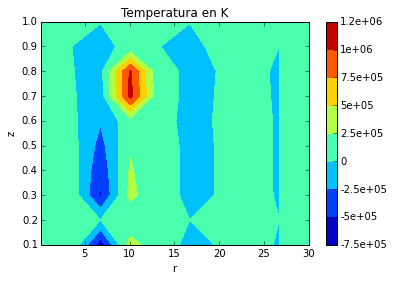

In [22]:
fig, axs = plt.subplots(1,1)
grap = axs.contourf(z, r, T_pres) 

fig.colorbar(grap, ax=axs, format="%.2g")

plt.title('Temperatura en K')
plt.ylabel('z')
plt.xlabel('r')
plt.savefig('temp.png')


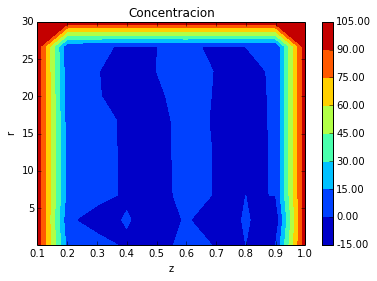

In [23]:
fig, axs = plt.subplots(1,1)
graph2 = axs.contourf(r, z, c_pres)
fig.colorbar(graph2, ax=axs , format="%.2f")
plt.title('Concentracion')
plt.ylabel('r')
plt.xlabel('z')
plt.savefig('concent.png')


In [ ]:
#escoger un tiempo dado y graficar la T y C haciendo variar el Z en 2D y variar el otro parametro
#O en 3D hacer un grafico de T Z C
#Los parametros pueden cambiar, esta bien pero R y L mejor dejarlos quietos

#Lambda 

#usar cobre como material del tubob y agua con flujo laminar

#las derivadas son continuas en los bordes. Condiciones tipo Dirichlet y Newmann 